In [1]:
#coding=utf-8
#!/usr/bin/env python3

#python train_CNN.py h5/axion1_40-250GeV_100k.h5

# import sys
# import os
# import random
# import pandas as pd
# import numpy as np
# import matplotlib as mpl
# import matplotlib.pyplot as plt

# import ROOT 

from h5py import File as HDF5File

# import tensorflow as tf
# from tensorflow import keras

# from keras.layers import Lambda, Input
# from keras.layers import Dropout, Flatten, Dense 
# import keras.backend as K
# from keras.models import Sequential, Model 
# from keras.layers.convolutional import Conv2D
# from keras.layers.pooling import MaxPooling2D
# from keras.layers.merge import concatenate


# Install TensorFlow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers , initializers
import tensorflow.keras.backend as K
from sklearn.preprocessing import StandardScaler
from joblib import dump, load


import numpy as np
from numpy import random
import matplotlib.pyplot as plt
# import autokeras as ak
import os 
import time
import importlib
import logging
from tqdm import tqdm

importlib.reload(logging)
logging.basicConfig(level = logging.INFO)

# limit GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
        
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)

logging.info("numpy Version is {}".format(np.__version__))
# logging.info("autokeras Version is {}".format(ak.__version__))
logging.info("tensorflow Version is {}".format(tf.keras.__version__))
logging.info("\n")


!nvidia-smi
%config InlineBackend. figure_format = 'retina'

IndexError: list index out of range

In [2]:
# for particle, datafile in s.iteritems():
def _load_data(particle, datafile):

    import h5py
    logging.info("load_data from datafile {}".format(datafile))
    d = h5py.File(datafile, 'r')
    first = np.expand_dims(d['layer_0'][:], -1)
    second = np.expand_dims(d['layer_1'][:], -1)
    third = np.expand_dims(d['layer_2'][:], -1)
    four = np.expand_dims(d['layer_3'][:], -1)
    energy = d['energy'][:].reshape(-1, 1) * 1000  # convert to MeV
    sizes = [first.shape[1], first.shape[2], second.shape[
        1], second.shape[2], third.shape[1], third.shape[2], four.shape[1], four.shape[2]]
    y = [particle] * first.shape[0]

    return first, second, third, four, y, energy, sizes


In [3]:
logging.info('part1')   

#s = pd.DataFrame({1000 : "h5/axion1_40-250GeV_100k.h5", 1000 : "h5/gamma_40-250GeV_100k.h5"}, index=["sig","bkg"]);
s = ["./h5/axion1_40-250GeV_100k.h5", "./h5/pi0_40-250GeV_100k.h5"]#, "./pi0_40-250GeV_100k.h5"];
events = [1000, 1000]#, 1000]

#<HDF5 dataset "energy": shape (100000, 1), type "<f8">
#<HDF5 dataset "layer_0": shape (100000, 4, 16), type "<f8">
#<HDF5 dataset "layer_1": shape (100000, 4, 128), type "<f8">
#<HDF5 dataset "layer_2": shape (100000, 16, 16), type "<f8">
#<HDF5 dataset "layer_3": shape (100000, 16, 8), type "<f8">
first, second, third, four, y, energy, sizes = [
    np.concatenate(t) for t in [
        a for a in zip(*[_load_data(1000, file) for file in s])
    ]
]

first_sig, second_sig, third_sig, four_sig, y_sig, energy_sig, sizes_sig = [
    np.concatenate(t) for t in [
        a for a in zip(*[_load_data(events[0], s[0])])
    ]
]
first_bkg0, second_bkg0, third_bkg0, four_bkg0, y_bkg0, energy_bkg0, sizes_bkg0 = [
    np.concatenate(t) for t in [
        a for a in zip(*[_load_data(events[1], s[1])])
    ]
]
# first_bkg1, second_bkg1, third_bkg1, four_bkg1, y_bkg1, energy_bkg1, sizes_bkg1 = [
#     np.concatenate(t) for t in [
#         a for a in zip(*[_load_data(events[2], s[2])])
#     ]
# ]

logging.info("\n")
logging.info("first {}".format(first.shape))
logging.info("first_sig {}".format(first_sig.shape))
# logging.info("second_sig {}".format(second_sig.shape))

#Prinf sizes
#logging.info("sizes_sig = ", sizes_sig)
#logging.info("sizes_bkg0 = ", sizes_bkg0)
#logging.info("sizes_bkg1 = ", sizes_bkg1)

# Use GeV for energy
first_sig, second_sig, third_sig, four_sig, energy_sig = [
    (X.astype(np.float32) / 1000)[:100000]
    for X in [first_sig, second_sig, third_sig, four_sig, energy_sig]
]
first_bkg0, second_bkg0, third_bkg0, four_bkg0, energy_bkg0 = [
    (X.astype(np.float32) / 1000)[:100000]
    for X in [first_bkg0, second_bkg0, third_bkg0, four_bkg0, energy_bkg0]
]

# first_bkg1, second_bkg1, third_bkg1, four_bkg1, energy_bkg1 = [
#     (X.astype(np.float32) / 1000)[:100000]
#     for X in [first_bkg1, second_bkg1, third_bkg1, four_bkg1, energy_bkg1]
# ]
    
logging.info("first {}".format(first.shape))
logging.info("first_sig {}".format(first_sig.shape))
# logging.info("second_sig {}".format(second_sig.shape))

INFO:root:part1
INFO:root:load_data from datafile ./h5/axion1_40-250GeV_100k.h5
INFO:root:load_data from datafile ./h5/pi0_40-250GeV_100k.h5
INFO:root:load_data from datafile ./h5/axion1_40-250GeV_100k.h5
INFO:root:load_data from datafile ./h5/pi0_40-250GeV_100k.h5
INFO:root:

INFO:root:first (200000, 4, 16, 1)
INFO:root:first_sig (100000, 4, 16, 1)
INFO:root:first (200000, 4, 16, 1)
INFO:root:first_sig (100000, 4, 16, 1)


In [4]:

inputs = ([(first, second)]) # Input Simulation
labels = np.concatenate((np.ones(first_sig.shape[0]), np.zeros(first_bkg0.shape[0])))
logging.info(labels.shape)
logging.info("label: {} {}".format(labels[0],labels[100000]))

INFO:root:(200000,)
INFO:root:label: 1.0 0.0


In [5]:



## Taken from https://tutorials.one/how-to-use-the-keras-functional-api-for-deep-learning/

# first input model
visible1 = Input(shape=(4,16,1), name="visible1")
conv11 = Conv2D(32, kernel_size=4, activation='relu', padding = "same", name="conv11")(visible1)
pool11 = MaxPooling2D(pool_size=(2, 2), name="pool11")(conv11)
conv12 = Conv2D(16, kernel_size=4, activation='relu', padding = "same", name="conv12")(pool11)
pool12 = MaxPooling2D(pool_size=(2, 2), name="pool12")(conv12)
logging.info("cov11.shape {}".format( conv11.shape))
logging.info("pool1.shape {}".format( pool11.shape))
logging.info("cov12.shape {}".format( conv12.shape))
logging.info("pool2.shape {}".format( pool12.shape))
flat1 = Flatten(name="flat1")(pool12)


# second input model
visible2 = Input(shape=(4,128,1),name="visible2")
conv21 = Conv2D(32, kernel_size=4, activation='relu', padding = "same",name="conv21")(visible2)
pool21 = MaxPooling2D(pool_size=(2, 2),name="pool21")(conv21)
conv22 = Conv2D(16, kernel_size=4, activation='relu', padding = "same",name="conv22")(pool21)
pool22 = MaxPooling2D(pool_size=(2, 2),name="pool22")(conv22)
flat2 = Flatten(name="flat2")(pool22)
logging.info("cov21.shape {}".format( conv21.shape))
logging.info("poo21.shape {}".format( pool21.shape)) 
logging.info("cov22.shape {}".format( conv22.shape)) 
logging.info("poo22.shape {}".format( pool22.shape)) 

# merge input models
merge = Concatenate(name="concatenate")([flat1, flat2])


# interpretation model
hidden1 = Dense(10, activation='relu',name="hidden1")(merge)
hidden2 = Dense(10, activation='relu',name="hidden2")(hidden1)
output = Dense(1, activation='sigmoid',name="output")(hidden2)
cnn = Model(inputs=[visible1, visible2], outputs=output)

cnn.compile(loss="binary_crossentropy", optimizer='adam', metrics=['acc'])
# summarize layers
logging.info(cnn.summary())
# plot graph
#plot_model(model, to_file='multiple_inputs.png')

#epoch = 5?




INFO:root:cov11.shape (None, 4, 16, 32)
INFO:root:pool1.shape (None, 2, 8, 32)
INFO:root:cov12.shape (None, 2, 8, 16)
INFO:root:pool2.shape (None, 1, 4, 16)
INFO:root:cov21.shape (None, 4, 128, 32)
INFO:root:poo21.shape (None, 2, 64, 32)
INFO:root:cov22.shape (None, 2, 64, 16)
INFO:root:poo22.shape (None, 1, 32, 16)
INFO:root:None


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
visible1 (InputLayer)           [(None, 4, 16, 1)]   0                                            
__________________________________________________________________________________________________
visible2 (InputLayer)           [(None, 4, 128, 1)]  0                                            
__________________________________________________________________________________________________
conv11 (Conv2D)                 (None, 4, 16, 32)    544         visible1[0][0]                   
__________________________________________________________________________________________________
conv21 (Conv2D)                 (None, 4, 128, 32)   544         visible2[0][0]                   
______________________________________________________________________________________________

In [6]:
history = cnn.fit(inputs, labels,  epochs=2, batch_size=100)

Epoch 1/2
2000/2000 [==============================] - 35s 18ms/step - loss: 0.2590 - acc: 0.9024
Epoch 2/2
2000/2000 [==============================] - 37s 18ms/step - loss: 0.1608 - acc: 0.9404


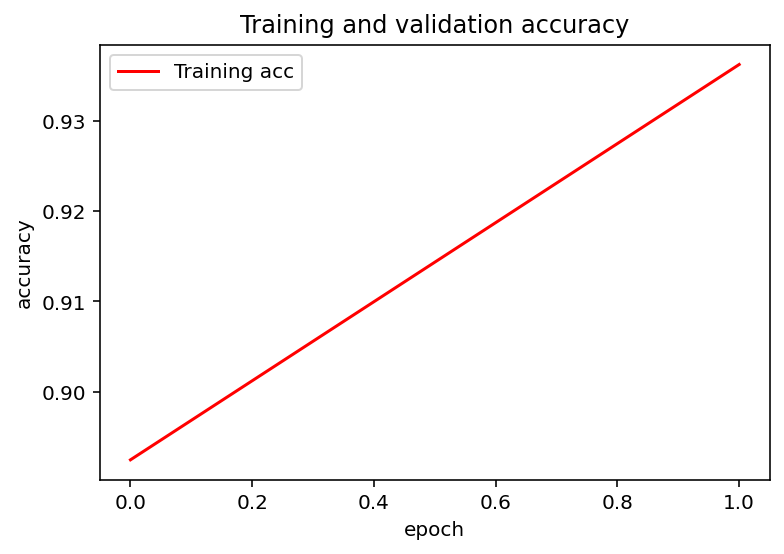

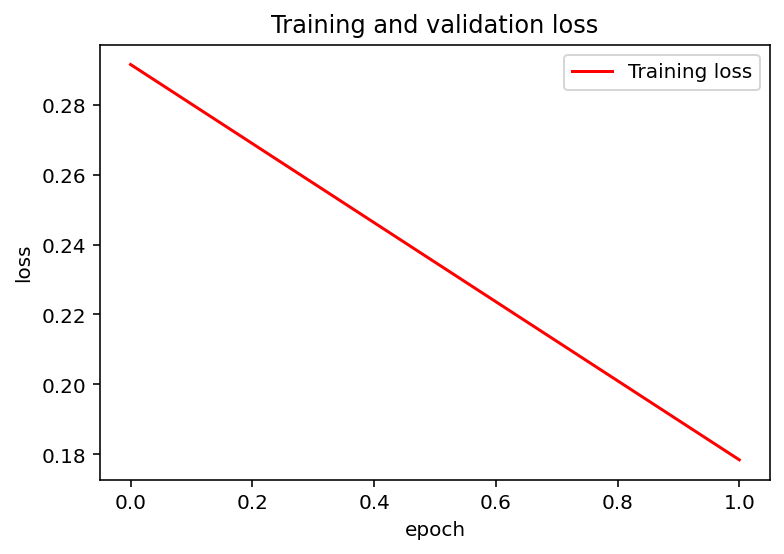

In [69]:

acc = history.history['acc']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

